In [1]:
# 0. Full reproducibility setup (like set.seed in R)

import os, random, numpy as np, tensorflow as tf

SEED = 42  # fixed seed value

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

try:
    tf.config.experimental.enable_op_determinism()
    print("Deterministic ops enabled.")
except Exception as e:
    print("Deterministic ops not available:", e)

print("Seed fixed:", SEED)
print("TensorFlow version:", tf.__version__)


Deterministic ops enabled.
Seed fixed: 42
TensorFlow version: 2.20.0


In [2]:
# 1. Imports and helper functions

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models

# Image preprocessing
def prepare_dl_data(data_path, target_size=(128, 128)):
    """
    Load JPGs from a folder and return X (images) and y (labels)
    Labels: cat -> 0, dog -> 1
    """
    filenames = [f for f in os.listdir(data_path) if f.lower().endswith(".jpg")]
    if not filenames:
        raise RuntimeError(f"No .jpg files found in {data_path}")

    X, y = [], []

    for filename in filenames:
        img_path = os.path.join(data_path, filename)
        img = Image.open(img_path).convert("RGB").resize(target_size)
        img_array = np.array(img).astype(np.float32) / 255.0

        prefix = filename.split(".")[0].lower()
        if prefix == "cat":
            label = 0
        elif prefix == "dog":
            label = 1
        else:
            continue  # skip unrecognized files

        X.append(img_array)
        y.append(label)

    X = np.stack(X)
    y = np.array(y, dtype=np.int64)
    return X, y


In [3]:
# 2. Load and split data

# Assuming notebook is in /notebooks and images in ../data_sample/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(PROJECT_ROOT, "data_sample")

print("Loading data from:", data_dir)
X_full, y_full = prepare_dl_data(data_dir, target_size=(128, 128))
print("Loaded:", X_full.shape, y_full.shape)
print("Class counts:", np.bincount(y_full))

# Split into train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.4, stratify=y_full, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

print("Train size:", len(y_train))
print("Val size:", len(y_val))
print("Test size:", len(y_test))
print("Val label counts:", np.bincount(y_val))

Loading data from: /Users/fangchengcheng/Desktop/pstat197a/module-4-vignette/data_sample
Loaded: (20, 128, 128, 3) (20,)
Class counts: [10 10]
Train size: 12
Val size: 4
Test size: 4
Val label counts: [2 2]


In [4]:
# 3. Build CNN model

input_shape = (128, 128, 3)

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

model = models.Sequential(
    [
        layers.Input(shape=input_shape),
        data_augmentation,

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),  # binary output
    ]
)

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,369 (32.36 MB)

 Trainable params: 8,482,369 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 4. Train model (with early stopping)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
)

history = model.fit(
    X_train,
    y_train.astype(np.float32),
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val.astype(np.float32)),
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9167 - loss: 0.2264 - val_accuracy: 1.0000 - val_loss: 0.2425 - learning_rate: 2.5000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.2428 - val_accuracy: 1.0000 - val_loss: 0.2415 - learning_rate: 2.5000e-05
Epoch 3/30


2025-12-03 19:12:33.245753: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9167 - loss: 0.3520 - val_accuracy: 1.0000 - val_loss: 0.2427 - learning_rate: 2.5000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9167 - loss: 0.2219 - val_accuracy: 1.0000 - val_loss: 0.2403 - learning_rate: 2.5000e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9167 - loss: 0.2111 - val_accuracy: 1.0000 - val_loss: 0.2363 - learning_rate: 2.5000e-05
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.2274 - val_accuracy: 1.0000 - val_loss: 0.2333 - learning_rate: 2.5000e-05
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9167 - loss: 0.2768 - val_accuracy: 1.0000 - val_loss: 0.2306 - learning_rate: 2.5000e-05
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9167 - loss: 0.3559 - val_accuracy: 1.0000 - val_loss: 0.2304 - learning_rate: 2.5000e-05
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.1834 - val_accu

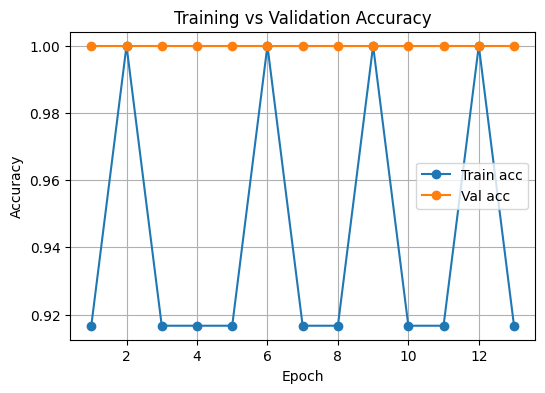

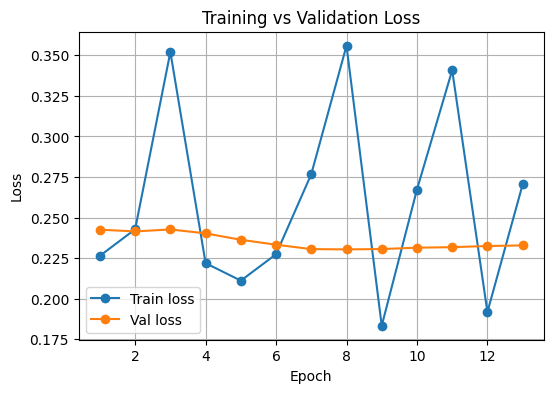

In [9]:
# 5. Plot training vs validation accuracy/loss

def plot_history(history_obj):
    acc = history_obj.history["accuracy"]
    val_acc = history_obj.history["val_accuracy"]
    loss = history_obj.history["loss"]
    val_loss = history_obj.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, acc, "o-", label="Train acc")
    plt.plot(epochs, val_acc, "o-", label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss, "o-", label="Train loss")
    plt.plot(epochs, val_loss, "o-", label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_history(history)

In [10]:
# 6. Evaluate on test set

test_loss, test_acc = model.evaluate(X_test, y_test.astype(np.float32), verbose=0)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Predictions
y_prob = model.predict(X_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["cat", "dog"]))


Test loss: 0.9950
Test accuracy: 50.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Confusion matrix (test):
[[0 2]
 [0 2]]

Classification report:
              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         2
         dog       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



2025-12-03 19:13:24.172341: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

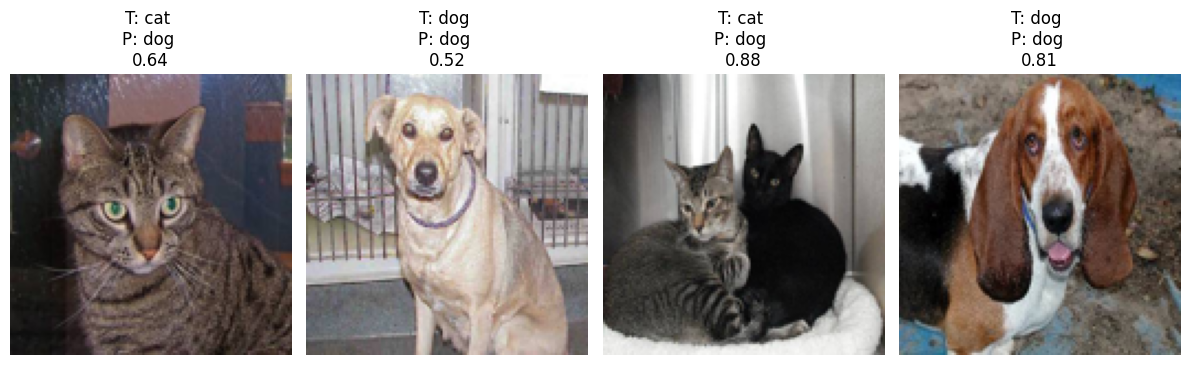

In [11]:
# 7. Visualize predictions

def show_examples(X, y_true, y_pred, y_prob, n=6):
    label_map = {0: "cat", 1: "dog"}
    n = min(n, len(X))
    indices = np.random.choice(len(X), n, replace=False)
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(indices):
        img = X[idx]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"T: {label_map[int(y_true[idx])]} \nP: {label_map[int(y_pred[idx])]} \n{y_prob[idx]:.2f}"
        )
    plt.tight_layout()
    plt.show()

show_examples(X_test, y_test, y_pred, y_prob, n=6)